# Project - Realtime Object Detection

## Importing Libraries

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

## Importing data

In [17]:
#Defining labels per dataset

# VisDrone categories of interest (ignore 0=ignored regions, 11=others)
visdrone_labels = {
    1: "pedestrian",
    2: "people",
    3: "bicycle",
    4: "car",
    5: "van",
    6: "truck",
    7: "tricycle",
    8: "awning-tricycle",
    9: "bus",
    10: "motor"
}

mot17_labels = {1: "pedestrian"}  # single-class

In [18]:
# --- Root directory for datasets ---
data_root = "../data"

# --- Training sequence definitions ---
train_folders = [
    {
        "dataset": "MOT17",
        "img_path": os.path.join(data_root, "MOT17/train/MOT17-04/img1"),
        "ann_path": os.path.join(data_root,"MOT17/train/MOT17-04/gt/gt.txt"),
        "type": "mot"
    },
    {
        "dataset": "VisDrone",
        "img_path": os.path.join(data_root, "VisDrone2019/train/sequences/uav0000366_00001_v"),
        "ann_path": os.path.join(data_root, "VisDrone2019/train/annotations/uav0000366_00001_v.txt"),
        "type": "visdrone"
    },
    {
        "dataset": "VisDrone",
        "img_path": os.path.join(data_root, "VisDrone2019/train/sequences/uav0000013_01073_v"),
        "ann_path": os.path.join(data_root, "VisDrone2019/train/annotations/uav0000013_01073_v.txt"),
        "type": "visdrone"
    }

    # Add more VisDrone sequences as needed
]


In [19]:
#Creating a unified load sequence with correct annotation parsing
def load_sequence(info):
    if info["type"] == "mot":
        img_dir = info["img_path"]
        gt_path = info["ann_path"]
        labels = mot17_labels
    elif info["type"] == "visdrone":
        img_dir = info["img_path"]
        gt_path = info["ann_path"]
        labels = visdrone_labels
    else:
        raise ValueError("Unsupported dataset type.")

    image_files = sorted([
        os.path.join(img_dir, f) for f in os.listdir(img_dir)
        if f.endswith('.jpg')
    ])

    annotations = {}

    with open(gt_path, 'r') as f:
        for line in f:
            fields = line.strip().split(',')
            if info["type"] == "mot":
                if len(fields) < 8:
                    continue
                try:
                    frame_id = int(fields[0])
                    x, y, w, h = map(float, fields[2:6])
                    mark = int(fields[6])
                    obj_class = int(float(fields[7]))
                except:
                    continue

                if mark != 1 or obj_class not in labels:
                    continue

            elif info["type"] == "visdrone":
                if len(fields) < 10:
                    continue
                try:
                    frame_id = int(fields[0])
                    x, y, w, h = map(float, fields[2:6])
                    score = int(float(fields[6]))
                    obj_class = int(float(fields[7]))
                except:
                    continue

                if obj_class not in labels or score != 1:
                    continue

            box = [x, y, x + w, y + h, obj_class]
            annotations.setdefault(frame_id, []).append(box)

    return image_files, annotations, labels

In [20]:
def show_frame_with_boxes(img_path, boxes, class_labels):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in boxes:
        x1, y1, x2, y2, cls = map(int, box)
        label = class_labels.get(cls, str(cls))
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

    plt.imshow(img)
    plt.axis('off')
    plt.show()


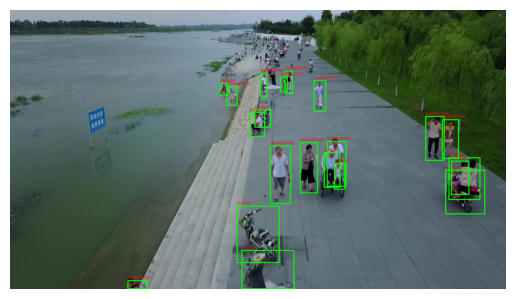

In [41]:
# Load a sequence (0 = MOT17, 1 = VisDrone)
sequence_info = train_folders[2]
img_files, annotations, labels = load_sequence(sequence_info)

# Show a frame
frame_id = 10
show_frame_with_boxes(img_files[frame_id], annotations.get(frame_id + 1, []), labels)


### Using Tensorflow for preprocessing the data

In [45]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
GRID_SIZE = 14  # from model
MAX_BOXES = GRID_SIZE * GRID_SIZE  # 196

# --- Step 1: Define preprocessing function ---
def preprocess_image_and_boxes(img_path, boxes):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    orig_shape = tf.shape(img)[:2]

    # Resize and normalize
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0

    # Convert to tensor
    boxes = tf.convert_to_tensor(boxes, dtype=tf.float32)

    # Rescale boxes
    scale_y = tf.cast(IMG_SIZE[0], tf.float32) / tf.cast(orig_shape[0], tf.float32)
    scale_x = tf.cast(IMG_SIZE[1], tf.float32) / tf.cast(orig_shape[1], tf.float32)
    
    boxes_scaled = tf.stack([
        boxes[:, 0] * scale_x,
        boxes[:, 1] * scale_y,
        boxes[:, 2] * scale_x,
        boxes[:, 3] * scale_y,
        boxes[:, 4]  # class ID
    ], axis=1)

    return img, boxes_scaled

In [46]:
# --- Step 2: Prepare image paths and boxes ---
all_img_paths = []
all_boxes = []
all_classes = set()

# train_folders is assumed to be defined already
for seq_info in train_folders:
    img_files, annotations, labels = load_sequence(seq_info)

    for frame_id, frame_path in enumerate(img_files):
        frame_key = frame_id + 1
        boxes = annotations.get(frame_key, [])
        if boxes:
            all_img_paths.append(frame_path)
            all_boxes.append(boxes)
            for box in boxes:
                all_classes.add(int(box[4]))

In [47]:
# --- Step 3: Normalize class IDs to 0-based continuous IDs ---
original_ids = sorted(list(all_classes))
class_id_map = {orig_id: new_id for new_id, orig_id in enumerate(original_ids)}
NUM_CLASSES = len(class_id_map)

# --- Step 4: Dataset generator ---
def generator():
    for img_path, box_list in zip(all_img_paths, all_boxes):
        new_box_list = []
        for box in box_list[:MAX_BOXES]:  # clip to MAX_BOXES
            new_box = box[:4] + [class_id_map[int(box[4])]]
            new_box_list.append(new_box)
        yield img_path, new_box_list

dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(None, 5), dtype=tf.float32)
    )
)

# --- Step 5: Apply preprocessing ---
dataset = dataset.map(preprocess_image_and_boxes, num_parallel_calls=tf.data.AUTOTUNE)

# --- Step 6: Pad, batch, prefetch ---
dataset = dataset.shuffle(512).padded_batch(
    BATCH_SIZE,
    padded_shapes=([IMG_SIZE[0], IMG_SIZE[1], 3], [MAX_BOXES, 5]),
    padding_values=(0.0, 0.0)
).prefetch(tf.data.AUTOTUNE)

def format_for_model(img, boxes_with_labels):
    bboxes = boxes_with_labels[:, :, :4]  # (batch, 196, 4)
    class_ids = boxes_with_labels[:, :, 4]  # (batch, 196)
    objectness = tf.cast(tf.not_equal(class_ids, 0), tf.float32)  # 1 if valid box, else 0
    return img, {
        "bbox": bboxes,
        "objectness": objectness,
        "class_logits": class_ids
    }

train_dataset = dataset.map(format_for_model)

In [48]:
# Optional: print sample batch
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("bbox shape:", labels["bbox"].shape)
    print("objectness shape:", labels["objectness"].shape)
    print("class_logits shape:", labels["class_logits"].shape)

Image batch shape: (8, 224, 224, 3)
bbox shape: (8, 196, 4)
objectness shape: (8, 196)
class_logits shape: (8, 196)


### Building a custom CNN model

In [49]:
def custom_detector_grid(input_shape=(224, 224, 3), num_classes=11):
    inputs = layers.Input(shape=input_shape)

    # --- Backbone ---
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)   # 112x112
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)   # 56x56
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)   # 28x28
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)   # 14x14 (spatial grid)

    # --- Detection Head ---
    # Each grid cell predicts 4 bbox coords + 1 objectness + num_classes class scores
    output_channels = 4 + 1 + num_classes  # 4 = bbox, 1 = objectness, N = class logits
    x = layers.Conv2D(output_channels, 1, padding="same")(x)  # output shape: (14, 14, C)

    # --- Reshape output ---
    x = layers.Reshape((14 * 14, output_channels))(x)  # (196, 4+1+N)

    bbox_out = layers.Lambda(lambda t: t[:, :, :4], name="bbox")(x)
    objectness_out = layers.Lambda(lambda t: t[:, :, 4], name="objectness")(x)
    class_out = layers.Lambda(lambda t: t[:, :, 5:], name="class_logits")(x)

    return models.Model(inputs=inputs, outputs=[bbox_out, objectness_out, class_out])


In [27]:
# #Loss Setup
# losses = {
#     "bbox": tf.keras.losses.MeanSquaredError(),
#     "class_logits": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# }


In [50]:
model = custom_detector_grid(
    input_shape=(224, 224, 3),
    num_classes=NUM_CLASSES
)

model.compile(
    optimizer="adam",
    loss={
        "bbox": tf.keras.losses.Huber(),
        "objectness": tf.keras.losses.BinaryCrossentropy(from_logits=False),
        "class_logits": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    }
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 28, 28,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 14, 14,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 14, 14,    │      3,084 │ max_pooling2d_7[… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 196, 12)   │          0 │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox (Lambda)       │ (None, 196, 4)    │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ objectness (Lambda) │ (None, 196)       │          0 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_logits        │ (None, 196, 7)    │          0 │ reshape_2[0][0]   │
│ (Lambda)            │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 391,500 (1.49 MB)

 Trainable params: 391,500 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.fit(train_dataset.repeat(), epochs=10, steps_per_epoch=176)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 232ms/step - bbox_loss: 17.3976 - class_logits_loss: 0.3077 - loss: 18.0441 - objectness_loss: 0.3393
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 250ms/step - bbox_loss: 15.1194 - class_logits_loss: 0.1195 - loss: 15.6150 - objectness_loss: 0.3761
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 247ms/step - bbox_loss: 14.6662 - class_logits_loss: 0.0850 - loss: 15.1067 - objectness_loss: 0.3555
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 245ms/step - bbox_loss: 13.6340 - class_logits_loss: 0.0582 - loss: 14.0584 - objectness_loss: 0.3663
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 242ms/step - bbox_loss: 11.9364 - class_logits_loss: 0.0499 - loss: 12.3658 - objectness_loss: 0.3798
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - bbox_loss: 10.6485 - class_logits_loss: 0.0629 - loss: 11.0623 - objectness_loss: 0.3514
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 247ms/step - bbox_loss: 9.7852 - class_logits_loss: 0.0345 - loss: 10.1784 - obj

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


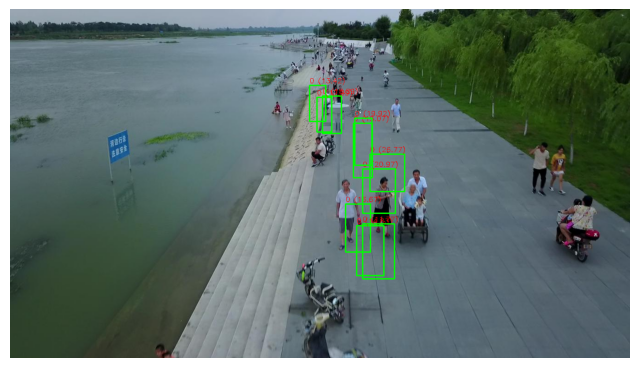

In [52]:
## Visualizing predictions on images

def visualize_predictions(model, img_path, label_map, threshold=0.3, top_k=20):
    # --- Load and preprocess image ---
    orig_img = cv2.imread(img_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    input_img = cv2.resize(orig_img, (224, 224)) / 255.0
    input_tensor = tf.expand_dims(input_img, axis=0)  # shape: (1, 224, 224, 3)

    # --- Get predictions ---
    bbox_pred, objectness_pred, class_logits = model.predict(input_tensor)
    objectness_pred = objectness_pred[0]
    bbox_pred = bbox_pred[0]
    class_probs = tf.nn.softmax(class_logits[0], axis=-1)

    # --- Filter predictions ---
    selected = tf.where(objectness_pred > threshold)
    selected = selected[:top_k]

    for i in selected:
        i = int(i)
        x1, y1, x2, y2 = bbox_pred[i]
        cls_id = tf.argmax(class_probs[i]).numpy()
        score = float(objectness_pred[i])
        label = label_map.get(cls_id, str(cls_id))

        # Rescale box to original image size
        h_scale = orig_img.shape[0] / 224
        w_scale = orig_img.shape[1] / 224
        x1 = int(x1 * w_scale)
        x2 = int(x2 * w_scale)
        y1 = int(y1 * h_scale)
        y2 = int(y2 * h_scale)

        # Draw box
        cv2.rectangle(orig_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(orig_img, f"{label} ({score:.2f})", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # --- Show image ---
    plt.figure(figsize=(8, 8))
    plt.imshow(orig_img)
    plt.axis('off')
    plt.show()


# Visualize prediction from your model on a training image
visualize_predictions(model, img_path=img_files[10], label_map=labels)